# Models for VALEO challenge.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import scipy

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, confusion_matrix, classification_report, precision_recall_curve
from sklearn.feature_selection import SelectKBest, f_classif  # variables ayant le lien le plus fort avec la target dans un test de anova
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline 

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

pd.set_option('display.max_row', 100)
pd.set_option('display.max_column', 100)
%pwd

'C:\\Users\\pierr\\REPERTOIRE_PROJETS_DATA\\VALEO_PROJECT'

# Dataset loading :

In [2]:
X = pd.read_csv('traininginputs.csv')
y = pd.read_csv('trainingoutput.csv')
X_true = pd.read_csv('testinputs.csv') 

# Remove useless columns

In [3]:
X = X.drop('PROC_TRACEINFO',axis=1)
y = y.drop('PROC_TRACEINFO',axis=1)
X_true = X_true.drop('PROC_TRACEINFO',axis=1)

col = X.columns

# Creating the train and test sets. Checking the good balance.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
y_train.value_counts()


Binar OP130_Resultat_Global_v
0                                27374
1                                  238
dtype: int64

In [5]:
y_test.value_counts()

Binar OP130_Resultat_Global_v
0                                6836
1                                  67
dtype: int64

# Preprocessing : 
# - NaN imputation
# - normalisation for gradient convergence
# - ADASYN sampling

In [6]:
imputer = X_train['OP100_Capuchon_insertion_mesure'].median()


def imputation(X_train, X_test, X_true): 
    X_train.loc[:,'OP100_Capuchon_insertion_mesure'] = X_train.loc[:,'OP100_Capuchon_insertion_mesure'] .fillna(imputer)
    X_test.loc[:,'OP100_Capuchon_insertion_mesure'] = X_test.loc[:,'OP100_Capuchon_insertion_mesure'].fillna(imputer)
    X_true.loc[:,'OP100_Capuchon_insertion_mesure'] = X_true.loc[:,'OP100_Capuchon_insertion_mesure'] .fillna(imputer)
    return X_train, X_test, X_true

X_train, X_test, X_true= imputation(X_train, X_test, X_true)   


C:\Users\pierr\anaconda3\lib\site-packages\pandas\core\indexing.py:1843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [7]:
def normalize(X_train, X_test, X_true): #
    scaler = StandardScaler()
    scaler.fit(X_train) 

    X_train = scaler.transform(X_train) 
    X_test = scaler.transform(X_test)  
    X_true = scaler.transform(X_true)
    
    X_train = pd.DataFrame(X_train, columns=col)
    X_test = pd.DataFrame(X_test, columns=col)
    X_true = pd.DataFrame(X_true, columns=col)
    
    return X_train, X_test, X_true


X_train, X_test, X_true = normalize(X_train, X_test, X_true)  

In [8]:
def sampling(X_train, y_train): 
    
    X_train,y_train = ADASYN().fit_sample(X_train,y_train)
    df = pd.concat([X_train,y_train],axis=1)
    df = df.sample(frac=1)#shuffle on rows
    
    X_train = df.drop('Binar OP130_Resultat_Global_v', axis=1)
    y_train = df['Binar OP130_Resultat_Global_v']
    
    return X_train, y_train


X_train, y_train = sampling(X_train, y_train)
X_train.shape

(54836, 13)

# Evaluation function and learning curves :

In [9]:
def evaluation(model, X, y, X_test,y_test):
                                      
    model.fit(X,y)
    
    #score on train
    ypred_X = model.predict(X)
    score_train = roc_auc_score(y, ypred_X)
    
    #score on test
    ypred_test = model.predict(X_test)
    score_test = roc_auc_score(y_test, ypred_test)
      
    
    return score_train, score_test

In [15]:
def curves(model,X, y, X_test,y_test):
    sizes = [1000,5000,10000,27000,50000]
    
    list_train=[]
    list_test=[]
    
    for i in sizes:     
        score_train, score_test = evaluation(model,X[0:i],y[0:i],X_test,y_test)
        list_train.append(score_train)
        list_test.append(score_test)

   
    
    plt.figure()
    plt.plot(sizes,list_test, label='test')
    plt.plot(sizes,list_train,label='train')
    plt.legend()

# First try : simple model


(1.0, 0.5191719867601722)


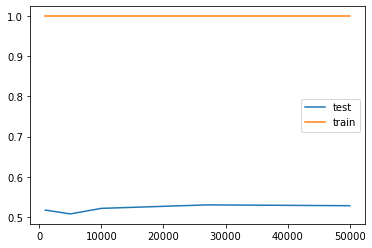

In [17]:
tree = DecisionTreeClassifier(random_state=0)

print(evaluation(tree,X_train,y_train,X_test,y_test))

curves(tree, X_train, y_train, X_test, y_test)

<AxesSubplot:>

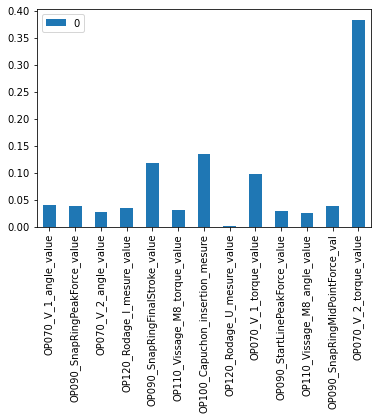

In [18]:
pd.DataFrame(tree.feature_importances_, index=X_train.columns).plot.bar()

# Second try : random forest

(0.8508367283818135, 0.6019372854859698)


<AxesSubplot:>

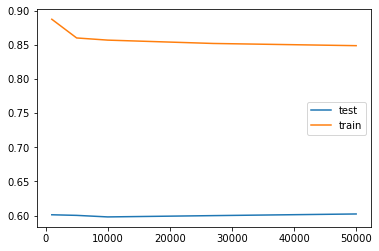

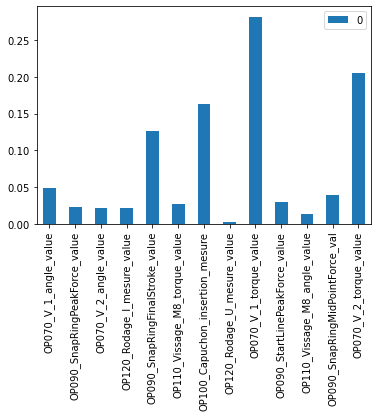

In [21]:
forest = RandomForestClassifier(max_depth= 5, random_state=0)

print(evaluation(forest,X_train,y_train,X_test,y_test))

curves(forest,X_train,y_train,X_test,y_test)

pd.DataFrame(forest.feature_importances_, index=X_train.columns).plot.bar()

# Third : logistic regression

(0.6437732415645294, 0.6011611049492153)


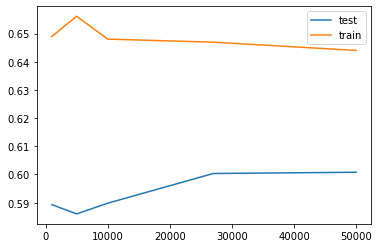

In [22]:
lr = LogisticRegression(random_state=0)

print(evaluation(lr, X_train, y_train, X_test, y_test))

curves(lr, X_train, y_train, X_test, y_test)


# MORE SYSTEMATIC : comparison of many models

In [26]:
#model list
tree = DecisionTreeClassifier(random_state=0)  #overfit
forest = RandomForestClassifier(max_features=3, random_state=0)#overfit
ada = AdaBoostClassifier(random_state=0)       #overfit
KNN = KNeighborsClassifier()                   #overfit
LR = LogisticRegression(random_state=0)       #underfit
SVM = SVC(random_state=0)                      #overfit
xc = xgb.XGBClassifier()                       #overfit
xr = xgb.XGBRegressor()                        #overfit
nb = GaussianNB()                              #overfit



In [27]:
list_of_models=[tree, forest, ada ,LR ,nb ,xc, xr]

for model in list_of_models:
    print(evaluation(model,X_train, y_train, X_test, y_test))
    #curves(model, X_train, y_train, X_test, y_test)   

(1.0, 0.5191719867601722)
(1.0, 0.5071701178135071)
(0.8728402849931033, 0.5897138066251538)
(0.6437732415645294, 0.6011611049492153)
(0.6477208978002252, 0.5352512597923199)


C:\Users\pierr\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:47:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
(0.9973599883475348, 0.5)
(0.9999102740703005, 0.6020977616306996)


# Pipelines to adress overfitting.

In [29]:
list_of_models=[tree, forest, ada, xc, LR, xr]

for model in list_of_models:
    pipe_overfiting = make_pipeline(SelectKBest(f_classif,k=4), model)
    print(evaluation(pipe_overfiting,X_train,y_train,X_test, y_test))

(0.9922802417886534, 0.5069506912482643)
(0.9922801832581511, 0.49970743124634287)
(0.8744121096586837, 0.5781507908089745)
[18:52:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\pierr\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


(0.991606115398834, 0.49992685781158575)
(0.6017865321069575, 0.5786223941730784)
(0.9983136670579749, 0.691703492484913)


In [30]:
pipe_underfiting = make_pipeline(PolynomialFeatures(2),LR)
print(evaluation(pipe_underfiting, X_train, y_train, X_test, y_test))

(0.7419471180956163, 0.5650867226186214)


C:\Users\pierr\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Curves for best model : xgboost

(0.9983136670579749, 0.691703492484913)


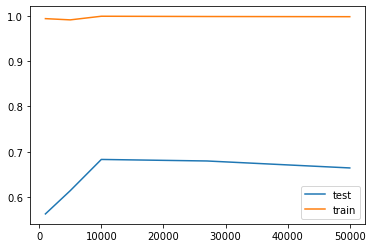

In [31]:
pipe_xgbr=make_pipeline(SelectKBest(f_classif,k=4),xr)

print(evaluation(pipe_xgbr,X_train,y_train,X_test,y_test))
curves(pipe_xgbr,X_train,y_train,X_test,y_test)

# Hyperparameters optimization by gridsearchCV

In [32]:
pipe_xgbr

Pipeline(steps=[('selectkbest', SelectKBest(k=4)),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.300000012, max_delta_step=0,
                              max_depth=6, min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=100,
                              n_jobs=8, num_parallel_tree=1, random_state=0,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                              subsample=1, tree_method='exact',
                              validate_parameters=1, verbosity=None))])

In [33]:
def grid_search_custom(X_train, y_train, X_test, y_test):
    
    #parameters
    k_list = range(2,10)
    depth_list = [2,4,8,16]
    rate_list = [0.0001, 0.001, 0.01, 0.1, 1]
    
    #initialisations:
    best_k = 2
    best_depth = 2
    best_rate = 0.001
    best_score = 0
    
    for r in rate_list:
        for d in depth_list:
            for kb in k_list:
                pipe_xgbr = make_pipeline(SelectKBest(f_classif,k=kb),xgb.XGBRegressor(learning_rate=r ,max_depth=d) )
                a, b =evaluation(pipe_xgbr,X_train,y_train,X_test,y_test)
                if b > best_score:
                    best_score=b
                    best_k=kb
                    best_depth=d
                    best_rate=r
                    best_modele=pipe_xgbr

    print('meilleur k:', best_k)
    print('meilleur score:',best_score)
    print('meilleur depth:', best_depth)
    print('meilleur rate:', best_rate)
    return best_modele

best_modele=grid_search_custom(X_train,y_train,X_test,y_test)

meilleur k: 4
meilleur score: 0.6699322288498991
meilleur depth: 8
meilleur rate: 0.1


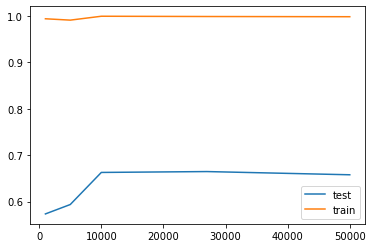

In [34]:
curves(best_modele, X_train, y_train, X_test, y_test)

# Formatting the submission for competition.

In [35]:
ypred=best_modele.predict(X_true)
ypred=ypred>0.5


df_out=pd.read_csv('Random_Submission_format.csv')
df_out['Binar OP130_Resultat_Global_v']=ypred

#export a dataframe in csv
df_out.to_csv('prediction finale valeo' ,index=False)

print(df_out)


                  PROC_TRACEINFO  Binar OP130_Resultat_Global_v
0     I-B-XA1207672-190520-00632                          False
1     I-B-XA1207672-190508-03689                          False
2     I-B-XA1207672-190715-00577                          False
3     I-B-XA1207672-190503-00796                          False
4     I-B-XA1207672-190712-01837                          False
...                          ...                            ...
7996  I-B-XA1207672-190905-03031                          False
7997  I-B-XA1207672-190531-00225                          False
7998  I-B-XA1207672-190424-03040                          False
7999  I-B-XA1207672-190715-00155                          False
8000  I-B-XA1207672-190503-00995                          False

[8001 rows x 2 columns]


# ----------------------PERSONNAL NOTES, DO NOT READ  --------------------


# gaussian multivariate from scratch

In [36]:
from scipy.stats import multivariate_normal


X=X_train.to_numpy()

m=X.shape[0]

mu=np.mean(X, axis=0)

V=X-mu

cov_matrix=1/m*(V.T).dot(V)

model_gaussien= multivariate_normal(mean=mu, cov=cov_matrix)

v_eval=model_gaussien.pdf(X) #fonction de densité du modèle

max=v_eval.max() #sur tout 
min=v_eval.min()

def eval(X_test,y_test,seuil):
        vecteur_valeurs=model_gaussien.pdf(X_test)
        mask=vecteur_valeurs<seuil
        return roc_auc_score(mask,y_test)      
        
meilleur_centile=0
meilleur_score=0

for i in range (1,100):
    seuil=scipy.stats.scoreatpercentile(v_eval, i)
    if eval(X_test,y_test,seuil)>meilleur_score:
        meilleur_centile=i
        meilleur_score=eval(X_test,y_test,seuil)
print(seuil)

print('melleur i',i)
print(meilleur_score)

3.376300297334849e-05
melleur i 99
0.5049214044366094
